<a href="https://colab.research.google.com/github/ebinjomonkottakal/Tensorflow_advanced/blob/main/FashionMNIST_using_Custom_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

**Load and Preprocess data**

In [2]:
train_data, info = tfds.load("fashion_mnist", split = "train",with_info=True)
test_data,info = tfds.load("fashion_mnist", split = "test",with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteEODAY6/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteEODAY6/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [35]:
class_names = ["T_shirt/Top","Trousers/Pantss","Pullover shirt","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Angle boot"]

In [3]:
def format_image(data):
  image = data['image']
  image = tf.reshape(image,[-1])
  image = tf.cast(image,'float32')
  image = image/255.0
  return image,data['label']


In [6]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [7]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test = test_data.batch(batch_size)

In [8]:
#define a model
def base_model():
  inputs = tf.keras.Input(shape = (784,),name = 'digits')
  x = tf.keras.layers.Dense(64,activation = 'relu',name = 'dense_1')(inputs)
  x = tf.keras.layers.Dense(64,activation = 'relu',name = 'dense_2')(x)
  outputs = tf.keras.layers.Dense(10,activation= 'softmax',name = 'predictions')(x)
  model = tf.keras.Model(inputs = inputs,outputs = outputs)
  return model

In [23]:
#optimizers and loss function
optimizers = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [24]:
# define metrics
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy()

In [29]:
def apply_gradient(optimizers,model,x,y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true = y,y_pred = logits)
  gradients = tape.gradient(loss_value,model.trainable_weights)
  optimizers.apply_gradients(zip(gradients,model.trainable_weights))
  return logits,loss_value

In [30]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total = len(list(enumerate(train))),position = 0,leave = True,bar_format = '{l_bar}{bar}|{n_fmt}{total_fmt}')
  for step,(x_batch_train,y_batch_train) in enumerate(train):
    logits, loss_value = apply_gradient(optimizers,model,x_batch_train,y_batch_train)
    losses.append(loss_value)
    train_acc_metric(y_batch_train,logits)
    pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
    pbar.update()
  return losses


In [31]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
    val_logits = model(x_val)
    val_loss = loss_object(y_true = y_val,y_pred = val_logits)
    losses.append(val_loss)
    val_acc_metric(y_val,val_logits)
  return losses

In [32]:
model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()


Start of epoch 0


  0%|          |0938WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7f95a921c430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Training loss for step 937: 0.3373: 100%|██████████|938938



 Epoch 0: Train loss: 0.5356  Validation Loss: 0.4472, Train Accuracy: 0.8130, Validation Accuracy 0.9963
Start of epoch 1


Training loss for step 937: 0.1234: 100%|██████████|938938



 Epoch 1: Train loss: 0.3896  Validation Loss: 0.4149, Train Accuracy: 0.8593, Validation Accuracy 0.9970
Start of epoch 2


Training loss for step 937: 0.5016: 100%|██████████|938938



 Epoch 2: Train loss: 0.3519  Validation Loss: 0.3945, Train Accuracy: 0.8726, Validation Accuracy 0.9967
Start of epoch 3


Training loss for step 937: 0.2398: 100%|██████████|938938



 Epoch 3: Train loss: 0.3302  Validation Loss: 0.3596, Train Accuracy: 0.8791, Validation Accuracy 0.9975
Start of epoch 4


Training loss for step 937: 0.1620: 100%|██████████|938938



 Epoch 4: Train loss: 0.3103  Validation Loss: 0.3831, Train Accuracy: 0.8863, Validation Accuracy 0.9975
Start of epoch 5


Training loss for step 937: 0.2952: 100%|██████████|938938



 Epoch 5: Train loss: 0.2973  Validation Loss: 0.3645, Train Accuracy: 0.8900, Validation Accuracy 0.9975
Start of epoch 6


Training loss for step 937: 0.1569: 100%|██████████|938938



 Epoch 6: Train loss: 0.2849  Validation Loss: 0.3681, Train Accuracy: 0.8933, Validation Accuracy 0.9978
Start of epoch 7


Training loss for step 937: 0.0707: 100%|██████████|938938



 Epoch 7: Train loss: 0.2749  Validation Loss: 0.3605, Train Accuracy: 0.8974, Validation Accuracy 0.9974
Start of epoch 8


Training loss for step 937: 0.2154: 100%|██████████|938938



 Epoch 8: Train loss: 0.2681  Validation Loss: 0.3576, Train Accuracy: 0.8993, Validation Accuracy 0.9975
Start of epoch 9


Training loss for step 937: 0.1694: 100%|██████████|938938



 Epoch 9: Train loss: 0.2589  Validation Loss: 0.3522, Train Accuracy: 0.9033, Validation Accuracy 0.9969


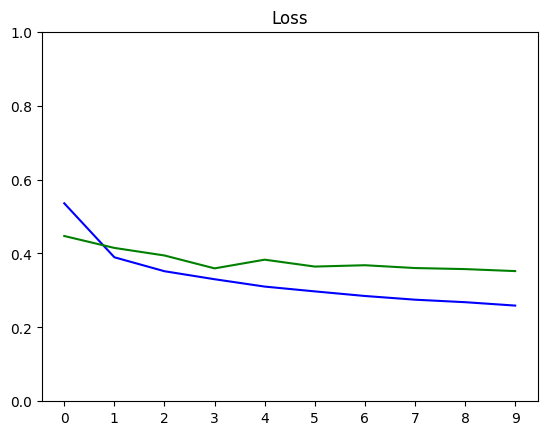

In [37]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

In [39]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

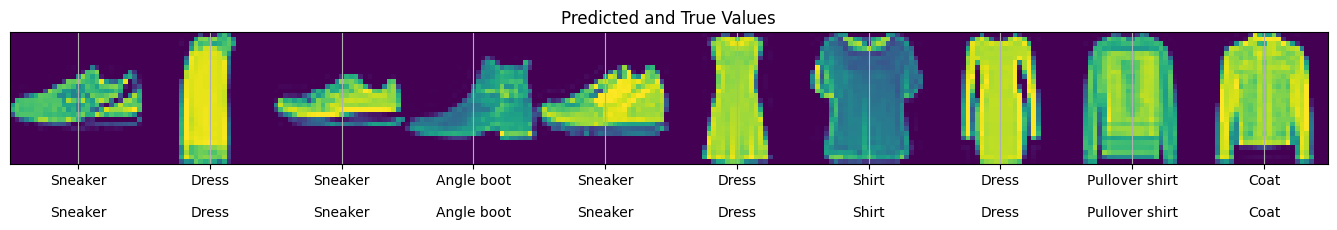

In [36]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)